**<h1>Data Preparation and Exploration**

In [2]:
# Importing Python libraries

import pandas as pd
import numpy as np

from datetime import datetime, timedelta





import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras import layers

import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [3]:
# Reading CSV files, the file was downloaded from 'https://finance.yahoo.com/quote/NVDA/history/'
df = pd.read_csv('NVDA.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6319 entries, 0 to 6318
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6319 non-null   object 
 1   Open       6319 non-null   float64
 2   High       6319 non-null   float64
 3   Low        6319 non-null   float64
 4   Close      6319 non-null   float64
 5   Adj Close  6319 non-null   float64
 6   Volume     6319 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 345.7+ KB


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6319.000000,6319.000000,6319.000000,6319.000000,6319.000000,6.319000e+03
mean,46.333376,47.175939,45.474042,46.374007,46.112849,6.088707e+07
std,101.765032,103.557399,99.951474,101.896433,101.921125,4.347832e+07
min,0.348958,0.355469,0.333333,0.341146,0.312949,1.968000e+06
25%,2.735989,2.831666,2.662500,2.734583,2.508557,3.468740e+07
50%,4.500000,4.574167,4.416667,4.505000,4.173921,5.100720e+07
75%,39.210001,39.790001,38.360000,39.252499,38.898155,7.394820e+07
max,841.299988,876.950012,837.190002,852.369995,852.369995,9.230856e+08


Statistical Data related to the stock trends, Mean stock value remained within 46-47 as the stock ramined latent till 2015 after listed in 1999

In [5]:
# Feature engineering, adding new columns on the basis of Date after converting Date dtype from string to date object
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] =  df['Date'].dt.day_name()
df['month_name'] = df['Date'].dt.month_name()
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

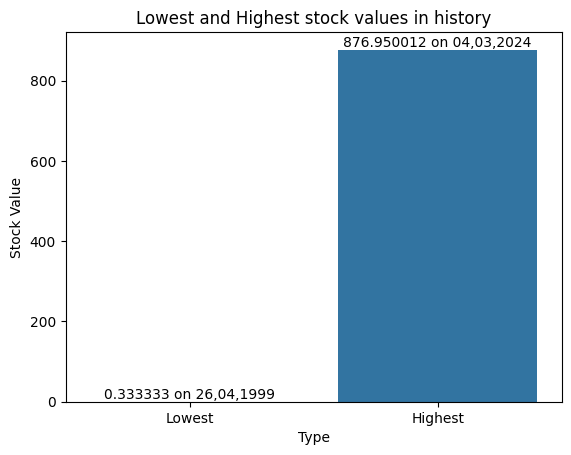

In [6]:
# Ploting graph to display the lowest and highest stock point in the history of the NVIDIA

lowest_value, low_loc = df['Low'].min(), df['Low'].idxmin()   # Lowest stock value and its location
highest_value, high_loc = df['High'].max(), df['High'].idxmax() # Highest stock value and its location

low_date = df['Date'][low_loc].strftime('%d,%m,%Y') # Date of lowest stock value
high_date = df['Date'][high_loc].strftime('%d,%m,%Y') # Date of highest stock value

ax = sns.barplot(x=['Lowest', 'Highest'], y=[lowest_value, highest_value])
ax.set_title('Lowest and Highest stock values in history')
ax.set_ylabel('Stock Value')
ax.set_xlabel('Type')

lowval = str(lowest_value) + ' on ' + str(low_date)
highval= str(highest_value) + ' on ' + str(high_date)
# Annotate the bars with dates
ax.text(0, lowest_value, lowval , ha='center', va='bottom')
ax.text(1, highest_value, highval, ha='center', va='bottom')

# Show the plot
plt.show()

In [7]:
# Create a figure object
fig = go.Figure()

# Add traces for each column (Open, High, Low, Close)
for column in ['Open', 'High', 'Low', 'Close']:
    fig.add_trace(go.Scatter(x=df['Date'], y=df[column], mode='lines+markers', name=column))

# Update layout
fig.update_layout(
    title="Nvidia Stock Price Over Time",
    xaxis_title="Date",
    yaxis_title="Price",
    showlegend=True,
    hovermode='x unified',
    xaxis=dict(type='date'), # Set x-axis as date
    height=600,
    width=1400
)

# Show the plot
fig.show()

The stock was listed on January 22, 1999. From plot, we can clearly see that the stock remained latent till 2015 possible due to the demand of CPU by Intel. The stock saw upward trend after 2015 due to demands in GPU for gaming or other purpose. In 2022, there was a significant decline in the stock's value, likely influenced by the effects of the COVID-19 pandemic. After that the stock rebounded and resumed its upward trajectory, achieving new milestones. This could also be caused by the popularity of AI and need of high end GPU for model training.

**<h4>Exploring the year in which Nvidia stock rose the most**

In [8]:
years = df['year'].unique()
stocks_yoy = dict(); Date = list(); Open = list(); Close = list(); Growth = list()
for year in years:
    open = df[df['year'] == year]['Open'].head(1).values[0]
    close = df[df['year'] == year]['Close'].tail(1).values[0]
    Date.append(year);    Open.append(open);    Close.append(close);    Growth.append(close - open)

stocks_yoy = {
    'Year':Date,
    'Open':Open,
    'Close':Close,
    'Growth':Growth
}
df1 = pd.DataFrame(stocks_yoy)

In [9]:
# Create figure
fig2 = go.Figure()

# Add bars for growth
fig2.add_trace(go.Bar(
    x=df1['Year'],
    y=df1['Growth'],
    hoverinfo='x+name+y',
    marker_color=['blue' if g >= 0 else 'red' for g in df1['Growth']],
    name='Growth'
))

# Add open and close values on hover
hover_text = [f'Open: {o:.2f}<br>Close: {c:.2f}' for o, c in zip(df1['Open'], df1['Close'])]
fig2.update_traces(text=hover_text, textposition='outside')

# Update layout
fig2.update_layout(
    title='Yearly Growth in stock price',
    xaxis_title='Year',
    yaxis_title='Growth',
    hovermode='closest',
    width=1400,  # Set width of the figure
    height=600  # Set height of the figure
)

# Show the plot
fig2.show()

Above graph dipslays the growth of stock within each year starting from Year 1999, on hovering user can see the growth value. Growth is calculated by the closing stock value of the last traiding day of the year - opening stock value of the first trading day of the year

In [10]:
# Create a figure object
fig1 = go.Figure()

# Add traces for all 'Open','Low','High','Close' columns for year 2024
for column in ['Open','Low','High','Close']:
    if column not in ['Date', 'Day', 'month_name']:
        fig1.add_trace(go.Scatter(x=df[df['year'] == 2024]['Date'], y=df[df['year'] == 2024][column], mode='lines+markers', name=column))

# Update layout
fig1.update_layout(
    title="Stock Prices during year 2024",
    xaxis_title="Date",
    yaxis_title="Value",
    showlegend=True,
    hovermode='x unified',
    xaxis=dict(type='date')  # Set x-axis as date
)

# Show the plot
fig1.show()


Since, we now know that the in year 2024, stock saw the highest growth, so we are plotting the daily graph to showcase the trends of the stock

**<h3>Stationarity Testing**

ADF Statistic: 5.326469398792568
p-value: 1.0
p-value is greater than or equal to 0.05. Data may not be stationary.


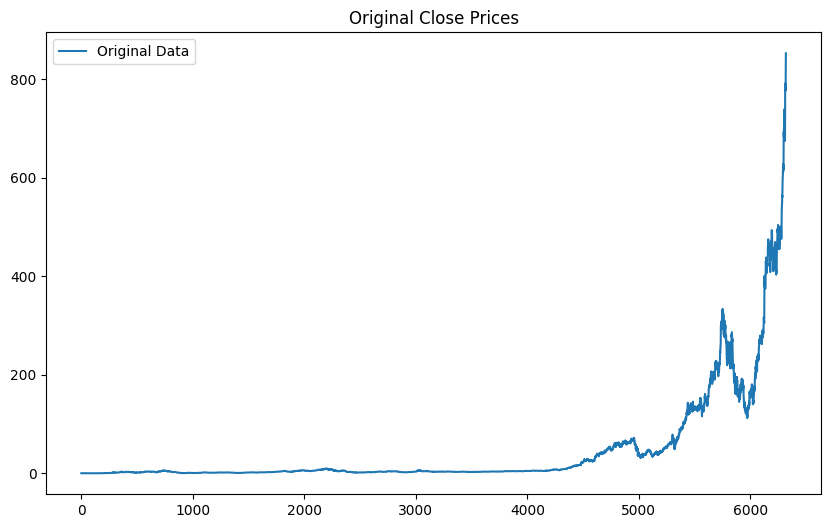

ADF Statistic after differencing: -4.679493843692903
p-value after differencing: 9.194247678293816e-05


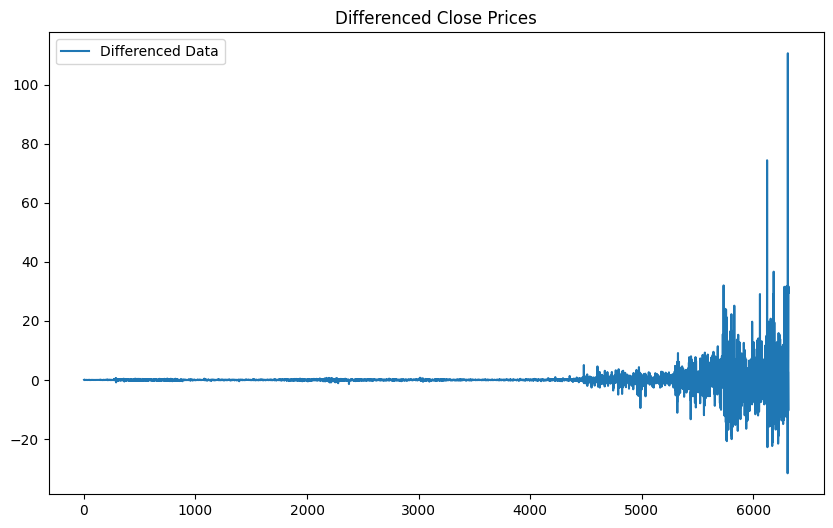

In [11]:
data = df[['Date', 'Close']]
# Perform ADF test
adf_result = adfuller(data['Close'])
adf_statistic = adf_result[0]
p_value = adf_result[1]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print('p-value is less than 0.05. Data is stationary.')
else:
    print('p-value is greater than or equal to 0.05. Data may not be stationary.')

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Original Data')
plt.title('Original Close Prices')
plt.legend()
plt.show()

# If data is not stationary, apply differencing
if p_value >= 0.05:
    # Perform differencing
    data['Close_diff'] = data['Close'] - data['Close'].shift(1)
    
    # Test again for stationarity
    adf_result_diff = adfuller(data['Close_diff'].dropna())
    adf_statistic_diff = adf_result_diff[0]
    p_value_diff = adf_result_diff[1]

    print('ADF Statistic after differencing:', adf_statistic_diff)
    print('p-value after differencing:', p_value_diff)

    # Plot differenced data
    plt.figure(figsize=(10, 6))
    plt.plot(data['Close_diff'], label='Differenced Data')
    plt.title('Differenced Close Prices')
    plt.legend()
    plt.show()

In [12]:
# Forecasting on Stationarity using SARIMA model

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data['Close_diff'][:train_size], data['Close_diff'][train_size:]

# Fit SARIMA model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # Example order
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate
mse = mean_squared_error(test, forecast)
print('Mean Squared Error:', mse)

Mean Squared Error: 60.44600782361676


In [13]:
# Forecasting on Stationarity using ARIMA model

# Fit ARIMA model
model = ARIMA(train, order=(5,1,0))  # Example order (p=5, d=1, q=0)
model_fit = model.fit()

# Forecast
forecast_index = test.index  # Use the index of the test data
forecast = model_fit.forecast(steps=len(test), index=forecast_index)

# Evaluate
mse = mean_squared_error(test, forecast)
print('Mean Squared Error:', mse)

Mean Squared Error: 60.22863499857793


In [14]:
df_new = df[['Date', 'Close']]
df_new.set_index('Date', inplace=True)

In [15]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        # Convert target_date to a Timestamp object for comparison
        target_date_timestamp = pd.Timestamp(target_date)

        # Subset the DataFrame based on the comparison
        df_subset = dataframe.loc[dataframe.index <= target_date_timestamp].tail(n + 1)

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_date = target_date + datetime.timedelta(days=1)
        if next_date > last_date:
            last_time = True

        target_date = next_date

        if last_time:
            break

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)

    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n - i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

In [16]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [19]:
def plot_predictions(X_train, y_train, X_val, y_val, X_test, y_test, model, dates_train, dates_val, dates_test):
    train_predictions = model.predict(X_train).flatten()
    val_predictions = model.predict(X_val).flatten()
    test_predictions = model.predict(X_test).flatten()

    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])
    plt.show()

In [21]:
model = Sequential([layers.Input((3, 1)),
				layers.LSTM(64),
				layers.Dropout(0.2),
				layers.Dense(32, activation='relu'),
				layers.Dropout(0.2),
				layers.Dense(32, activation='relu'),
				layers.Dense(1)])	

model.compile(loss="mean_squared_error",
			optimizer=Adam(learning_rate=0.001),
			metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10, mode='min', restore_best_weights=True)

In [24]:
windowed_df = df_to_windowed_df(df_new, '2021-01-01', '2024-03-04', n=3)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

q_80 = int(len(dates) * .8); q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=128, verbose=1, callbacks=[es_callback])

plot_predictions(X_train, y_train, X_val, y_val, X_test, y_test, model, dates_train, dates_val, dates_test)

AttributeError: type object 'datetime.datetime' has no attribute 'timedelta'

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

In [ ]:
windowed_df = df_to_windowed_df(df_new, '2021-01-01', '2024-03-04', n=3)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

: 

In [ ]:
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])